Coupling map:


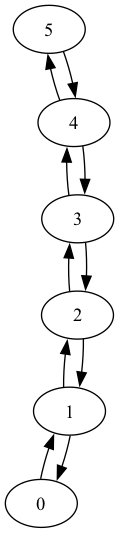

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

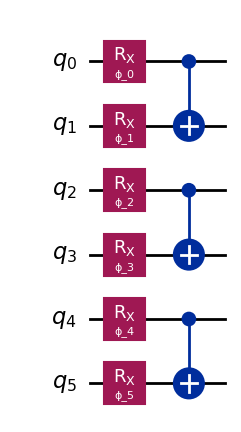

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


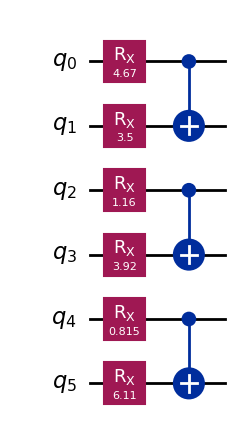

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


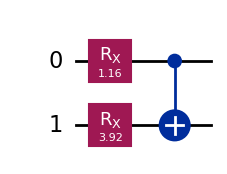

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

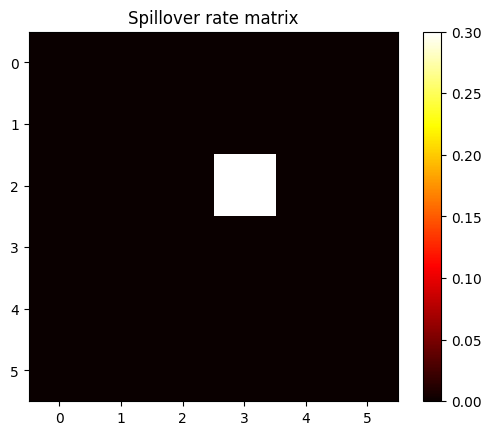

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.3  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)
# gamma_matrix = 0.05 * np.eye(num_qubits)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.3, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ]])

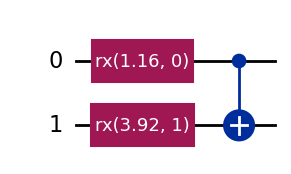

In [7]:
pass_ = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
pm = PassManager([pass_])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j],
       [0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [9]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [10]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '92e31156b12e4238887b256b77bc59bf',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.98488085+0.j        , 0.        -0.17323314j],
              [0.        -0.17323314j, 0.98488085+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [11]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager([pass_] + full_pm.translation._tasks[0])
full_pm.translation = custom_translation_pass

In [12]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x1531fca50>,

In [13]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [14]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '92e31156b12e4238887b256b77bc59bf',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.98488085+0.j        , 0.        -0.17323314j],
              [0.        -0.17323314j, 0.98488085+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [15]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


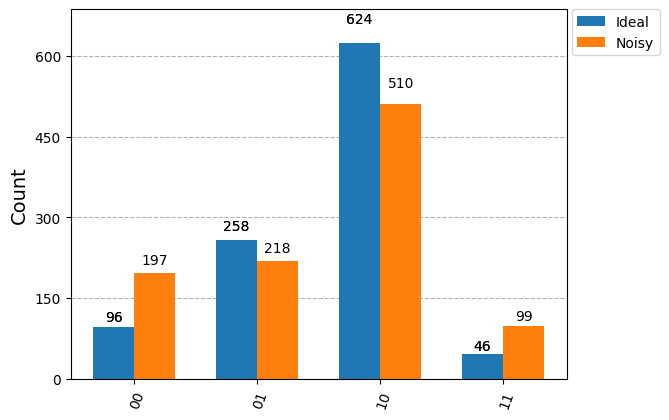

In [16]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [17]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [18]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9759922243907753

In [19]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [63]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)
# from gate_level.spillover_noise_use_case.generic_spillover.local_spillover_env import (
#     LocalSpilloverEnvironment,
# )

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        # n_reps=[3, 6, 9, 12],
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)
# q_env = LocalSpilloverEnvironment(
#     q_env_config,
#     circuit_context=circuit.assign_parameters(param_dict),  # Pass the circuit already transpiled through custom pass
# )
# q_env = ArbitraryAngleSpilloverEnv(
#     q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
# )

In [64]:
from typing import Optional, Dict, Any, SupportsFloat
from rl_qoc.environment.context_aware_quantum_environment import ObsType, ActType

class OneParamAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params,
        discrete_history_length,
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-np.pi] * 1),
            high=np.array([np.pi] * 1),
            dtype=np.float64,
        )

        self.discrete_reward_history = np.ones((discrete_history_length, self.num_params))
        self.discrete_obs_vals = np.linspace(
            self.observation_space.low, self.observation_space.high, self.num_params
        ).flatten()
        print(f"Observation Vals: {self.discrete_obs_vals}")
        self.obs_angles = np.zeros(self.observation_space.shape)

    def define_target_and_circuits(self):
        """
        Define the target gate and the circuits to be executed
        """
        circuit_context = causal_cone_circuit(
            self.circuit_context, list(self.config.env_metadata["target_subsystem"])
        )[0]
        self._physical_target_qubits = list(range(circuit_context.num_qubits))
        self._circuit_context = circuit_context
        target, custom_circuits, baseline_circuits = (
            super().define_target_and_circuits()
        )

        return target, custom_circuits, baseline_circuits

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        :param seed: Seed for the environment
        :param options: Options for the environment
        :return: Initial observation and info
        """

        # Reset the environment
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
        else:
            self.obs_angles = self._get_new_angles()

        phi = np.zeros(self.unbound_circuit_context.num_qubits)
        phi[2] = self.obs_angles[0]
        # phi[3] = self.obs_angles[0]

        param_dict = {self.circuit_parameters[i].name: phi[i] for i in range(len(phi))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        # Generate the initial observation
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", phi)
        print(f"Environment Observation: {env_obs}")
        # Return the initial observation and info
        return env_obs, {}
    
    def _get_new_angles(self):
        if self.circuit_param_distribution == "uniform":
            angles = np.random.uniform(
                self.observation_space.low, self.observation_space.high, self.observation_space.shape
            )
        if self.circuit_param_distribution == "simple_discrete":
            self.prob_weights = np.ones_like(self.discrete_obs_vals)
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                p=self.prob_weights,
                replace=True
            )
        if self.circuit_param_distribution == "moving_discrete":
            self.prob_weights = (np.mean(
                self.discrete_reward_history, axis=0
            ) + np.log10(self.optimal_error_precision)) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                replace=True,
                p=self.prob_weights
            )
        return angles
    
    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        print(f"batch action shape: {action.shape}")
        
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info
    
    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals - obs * np.pi))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )
    
    # def initialize_discrete_history(self):
    #     # Initializes Discrete History with success of zeros policy
    #     for set_obs in np.tile(self.discrete_obs_vals, (self.discrete_history_length,)):
    #         _obs, info = self.reset(debug_obs=np.array([set_obs]))
    #         obs, reward, terminated, truncated, info = self.step(np.zeros((self.batch_size,) + self.action_space.shape))
    
    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        :return: Observation
        """
        return self.obs_angles / np.pi # Normalized to multiples of pi

    def _get_info(self) -> Any:
        return {}

In [65]:
q_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [66]:
print(q_env.batch_size)

32


In [67]:
# q_env.clear_history()
for set_obs in q_env.discrete_obs_vals:
    # _obs, info = q_env.reset(debug_obs=np.array([1.]))
    _obs, info = q_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((32,) + q_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = q_env.step(zero_action)
    print(f"discrete reward history: {q_env.discrete_reward_history}")

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.8351141009169893
Reward (avg): 0.3901705929415379 Std: 0.012577301368913583
obs: [-1.]
reward: [0.22839661 0.21589387 0.22966957 0.22929971 0.21912216 0.21241592
 0.21654963 0.21460305 0.2192365  0.21053082 0.21214859 0.21332573
 0.20473052 0.19926971 0.21920245 0.21077627 0.21919236 0.19522294
 0.20485795 0.21450477 0.19819339 0.22814487 0.23135882 0.21044487
 0.21706159 0.21482129 0.22197791 0.20978074 0.20914768 0.20673287
 0.21729349 0.22237637]
discrete reward history: [[0.21488384 1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.     

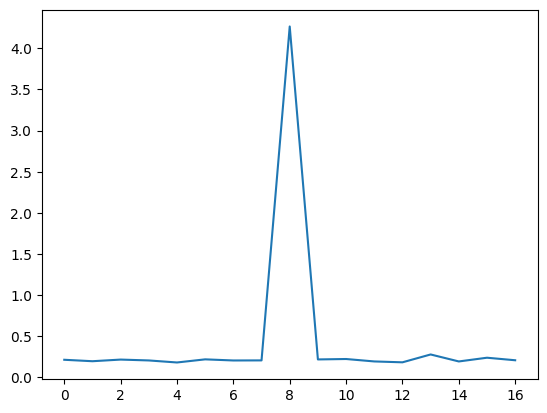

In [71]:
plt.plot(q_env.discrete_reward_history[0])

In [41]:
_obs, info = q_env.reset(debug_obs=np.array([1.]))
zero_action = np.zeros((32,) + q_env.action_space.shape)

print(q_env.batch_size)

reward = q_env.perform_action(zero_action)

Sampled angles:  [0. 0. 1. 0. 0. 0.]
Environment Observation: [0.31830989]
32
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9821345956502423
Reward (avg): 0.31623632162699006 Std: 0.01062403875320686


In [24]:
print(reward)

[0.26183459 0.25286712 0.24525805 0.25741018 0.26761087 0.26822087
 0.24420443 0.27100373 0.26158238 0.26537072 0.25817096 0.287905
 0.26088838 0.28120508 0.28645223 0.26318865 0.27432159 0.25798488
 0.26388767 0.2689062  0.2639512  0.25177562 0.24461694 0.26380851
 0.2358811  0.28544519 0.26310748 0.2422575  0.2448565  0.26757849
 0.26508488 0.27418217]


In [25]:
print(q_env.config.reward_method)

channel


In [26]:
_obs, info = q_env.reset(debug_obs=np.array([0.]))
_stuff = q_env.step(zero_action)


 Number of repetitions: 9
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0


Reward (avg): 0.9976924653591782 Std: 0.010905083629479095
obs: [0.]
reward: [3.17563617 6.         1.86426354 1.84279986 2.26119723 1.86949035
 1.73413735 6.         6.         2.10351347 6.         6.
 6.         2.6631251  6.         1.8537241  1.81806114 2.03550902
 2.67563002 1.66065443 6.         6.         2.08104785 1.91474791
 6.         6.         1.9276507  2.23010685 6.         1.76431152
 6.         6.        ]


In [27]:
print(_stuff[1].shape)

(32,)


In [28]:
np.array(reward).shape

(32,)

In [29]:
print(reward)

[0.26183459 0.25286712 0.24525805 0.25741018 0.26761087 0.26822087
 0.24420443 0.27100373 0.26158238 0.26537072 0.25817096 0.287905
 0.26088838 0.28120508 0.28645223 0.26318865 0.27432159 0.25798488
 0.26388767 0.2689062  0.2639512  0.25177562 0.24461694 0.26380851
 0.2358811  0.28544519 0.26310748 0.2422575  0.2448565  0.26757849
 0.26508488 0.27418217]


In [49]:
print(q_env._get_obs())

[-0.375]


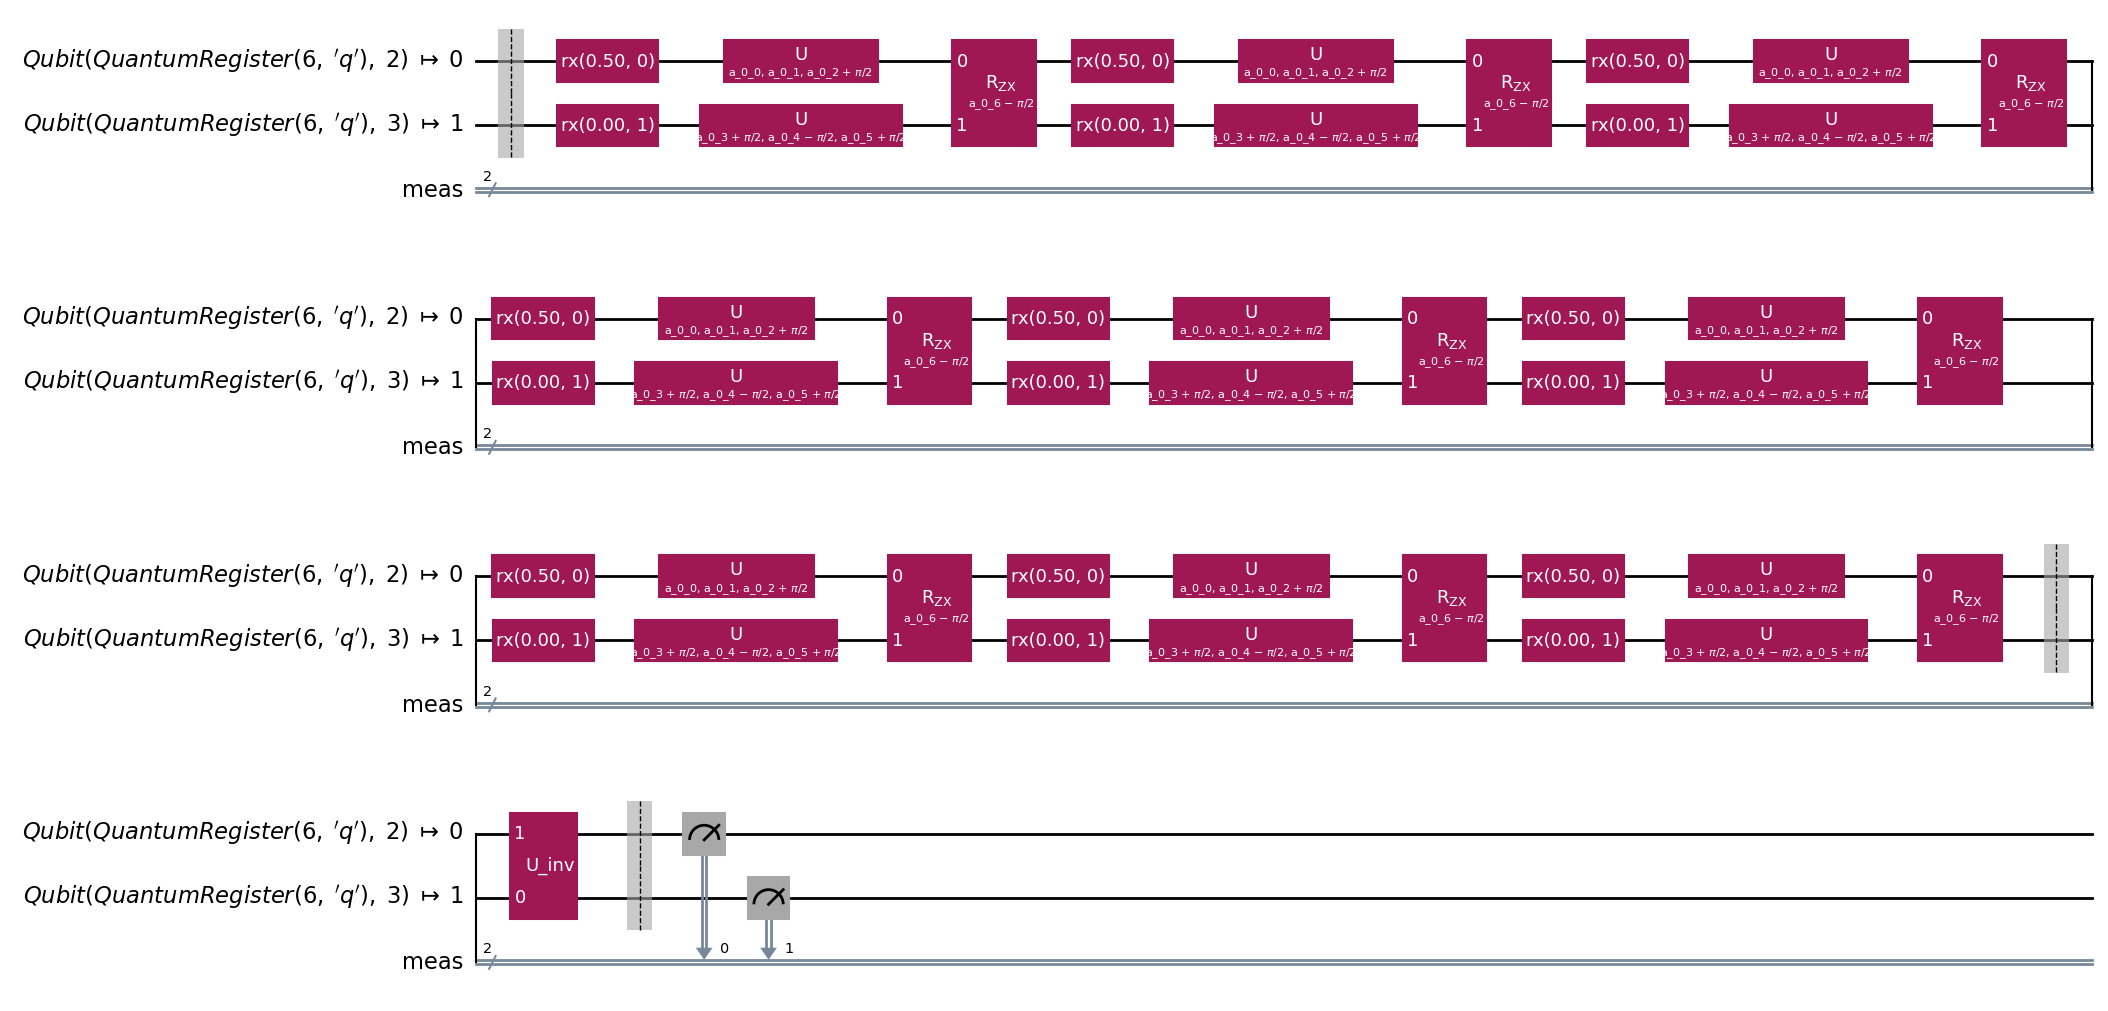

In [53]:
q_env.pubs[0].circuit.draw("mpl")

In [54]:
print(q_env.mean_action)

[0. 0. 0. 0. 0. 0. 0.]



 Number of repetitions: 7
Sampled angles:  [0.  0.  0.5 0.  0.  0. ]
Environment Observation: [0.15915494]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9955084311744169
Reward (avg): 0.536875 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9955084311744169
Reward (avg): 0.39125 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9955084311744169
Reward (avg): 0.49812499999999993 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9955084311744169
Reward (avg): 0.37625000000000003 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9955084311744169
Reward (avg): 0.4225 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9955084311744169
Reward (avg): 0.341875 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  

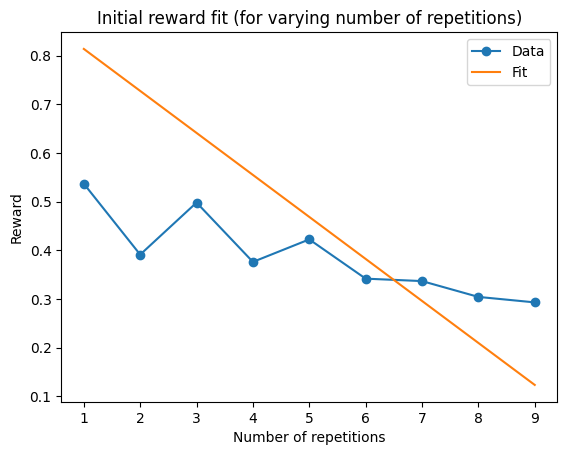

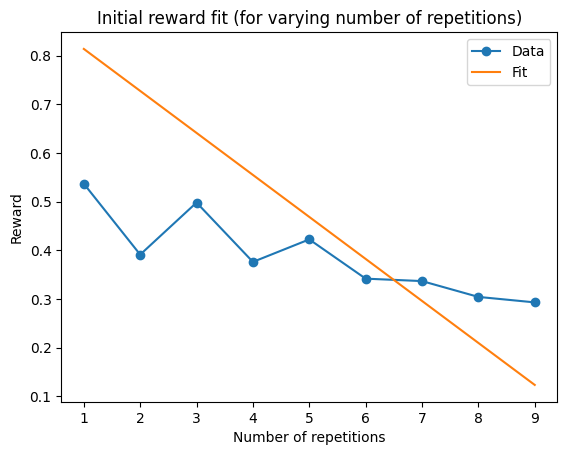

In [51]:
_obs, info = q_env.reset(debug_obs=np.array([0.5]))

q_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 10),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="cafe",
)

In [72]:
from arbitrary_angle_spillover_env import ArbitraryAngleSpilloverEnv

a_env = ArbitraryAngleSpilloverEnv(
    q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [75]:
_obs, info = a_env.reset()


 Number of repetitions: 1
Sampled angles:  [3.33963104 5.58711255 3.74894089 1.44824163 2.33898309 4.5937506 ]


Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7725852697486999
Reward (avg): 0.3408213266609243 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7725852697486999
Reward (avg): 0.22567967921353552 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7725852697486999
Reward (avg): 0.2011276658155155 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7725852697486999
Reward (avg): 0.267094105615302 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7725852697486999
Reward (avg): 0.3948215143070257 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7725852697486999
Reward (avg): 0.3627659872548367 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7725852697486999
Reward (avg): 0.2977326958124856 Std: 0.0
Starti

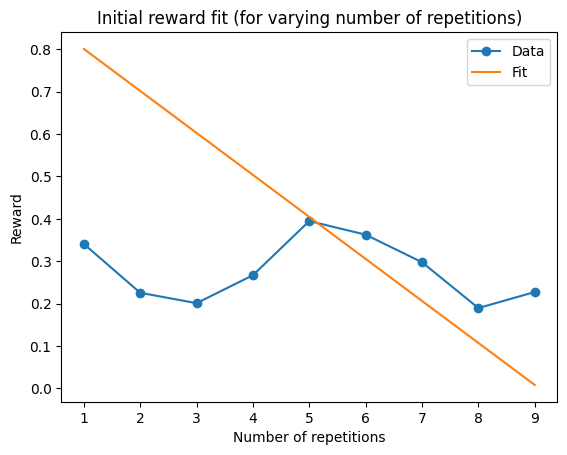

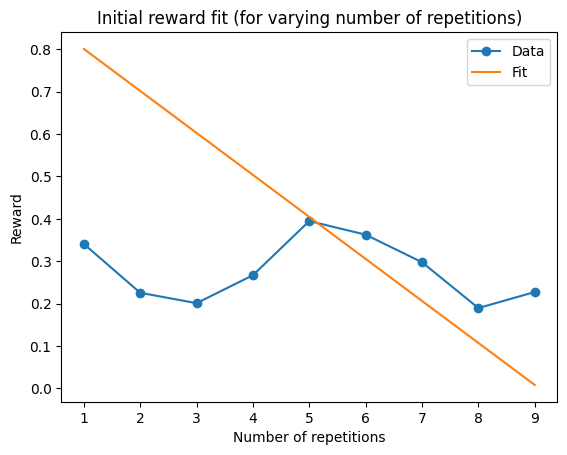

In [76]:
a_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 10),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="channel",
)

In [ ]:
print(a_env.)

In [32]:
_obs, info = a_env.reset()
reward = a_env.perform_action(zero_action)

print(reward)


 Number of repetitions: 3
Sampled angles:  [3.33963104 5.58711255 3.74894089 1.44824163 2.33898309 4.5937506 ]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7725852697486999
Reward (avg): 0.22173190469561777 Std: 0.013507389382757022
[0.22609876 0.21147619 0.2285885  0.20065194 0.24668891 0.231216
 0.20817012 0.23587711 0.22777553 0.21988337 0.23102531 0.22875999
 0.21734316 0.20142418 0.22785419 0.24440272 0.20272957 0.22591898
 0.21459824 0.21047087 0.21707492 0.23276468 0.22441436 0.23746161
 0.20904409 0.23640472 0.20395064 0.20975798 0.20682327 0.24902228
 0.20729979 0.22044895]


In [33]:
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

In [34]:
q_env.reset(debug_obs=np.array([1.]))
q_env.reset()


 Number of repetitions: 9
Sampled angles:  [0. 0. 1. 0. 0. 0.]
Environment Observation: [0.31830989]

 Number of repetitions: 3
Sampled angles:  [ 0.          0.         -0.78539816  0.          0.          0.        ]
Environment Observation: [-0.25]


(array([-0.25]), {})

In [35]:
# Testing reward history updates
q_env.clear_history()

print(q_env.discrete_reward_history.shape)
print(q_env.discrete_reward_history)

(3, 17)
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [56]:
print(q_env.batch_size)

100


In [58]:
q_env.clear_history()
for set_obs in q_env.discrete_obs_vals:
    # _obs, info = q_env.reset(debug_obs=np.array([1.]))
    _obs, info = q_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((32,) + q_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = q_env.step(zero_action)
    print(f"discrete reward history: {q_env.discrete_reward_history}")


 Number of repetitions: 6
Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)


ValueError: Action batch size 32 does not match environment batch size 100

In [37]:
q_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 10),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method=None,
)

Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.8351141009169893
Reward (avg): 0.3618931166411083 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.8351141009169893
Reward (avg): 0.26601520117758637 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.8351141009169893
Reward (avg): 0.19627685919016097 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.8351141009169893
Reward (avg): 0.23758417853736705 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.8351141009169893


KeyboardInterrupt: 

In [ ]:
print(q_env.discrete_reward_history)
print(q_env.discrete_reward_history.shape)
print(np.round(q_env.discrete_reward_history))

[[0.09199469 0.10596499 0.33150465 0.11018024 0.17471972 0.09846761
  0.14886434 0.32881463 6.         0.1572414  0.2630351  0.12765156
  0.11952807 0.19484568 0.14103236 0.15373292 0.07178192]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.        ]]
(3, 17)
[[0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


(3, 17)
(17,)


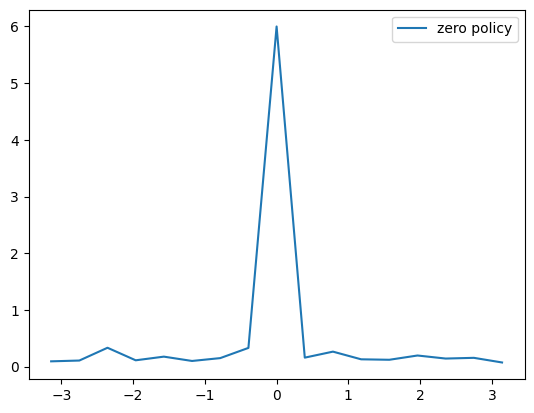

In [ ]:
print(q_env.discrete_reward_history.shape)
mean_reward_history = np.mean(q_env.discrete_reward_history, axis=0)
print(mean_reward_history.shape)

plt.plot(q_env.discrete_obs_vals, q_env.discrete_reward_history[0], label='zero policy')
plt.legend()
plt.show()

(3, 17)
(17,)


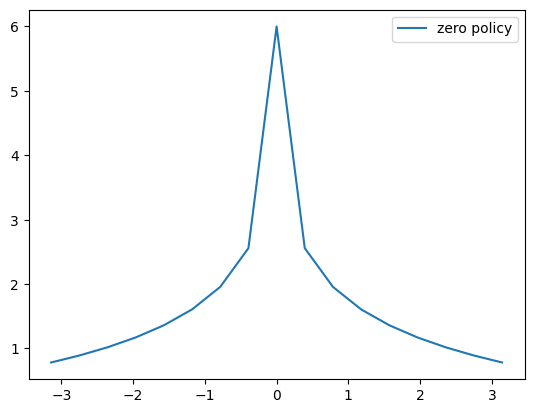

In [ ]:
print(q_env.discrete_reward_history.shape)
mean_reward_history = np.mean(q_env.discrete_reward_history, axis=0)
print(mean_reward_history.shape)

plt.plot(q_env.discrete_obs_vals, q_env.discrete_reward_history[0], label='zero policy')
plt.legend()
plt.show()

In [ ]:
q_env.backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': 'a8c8b0498e224c62b011d279b06cc53c',
   'operations': ['rx(0.00, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.89100652+0.j       , 0.        -0.4539905j],
              [0.        -0.4539905j, 0.89100652+0.j       ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

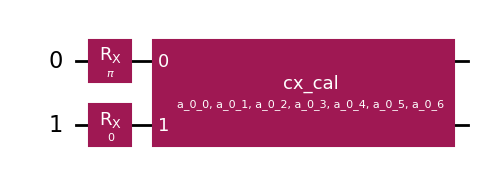

In [ ]:
q_env.circuits[0].draw("mpl")

In [ ]:
q_env.target_instruction

CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())

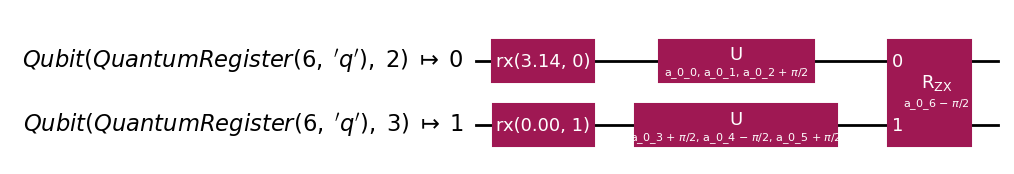

In [ ]:
q_env.backend_info.custom_transpile(
    q_env.circuits[0], initial_layout=q_env.target.layout
).draw("mpl")

In [ ]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

q_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 800,
    "learning_rate": 1e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

q_env.clear_history()
ppo_agent = PPO_CleanRL(agent_config, q_env)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [ ]:
print(ppo_agent.env.observation_space)

Box(-3.141592653589793, 3.141592653589793, (1,), float64)


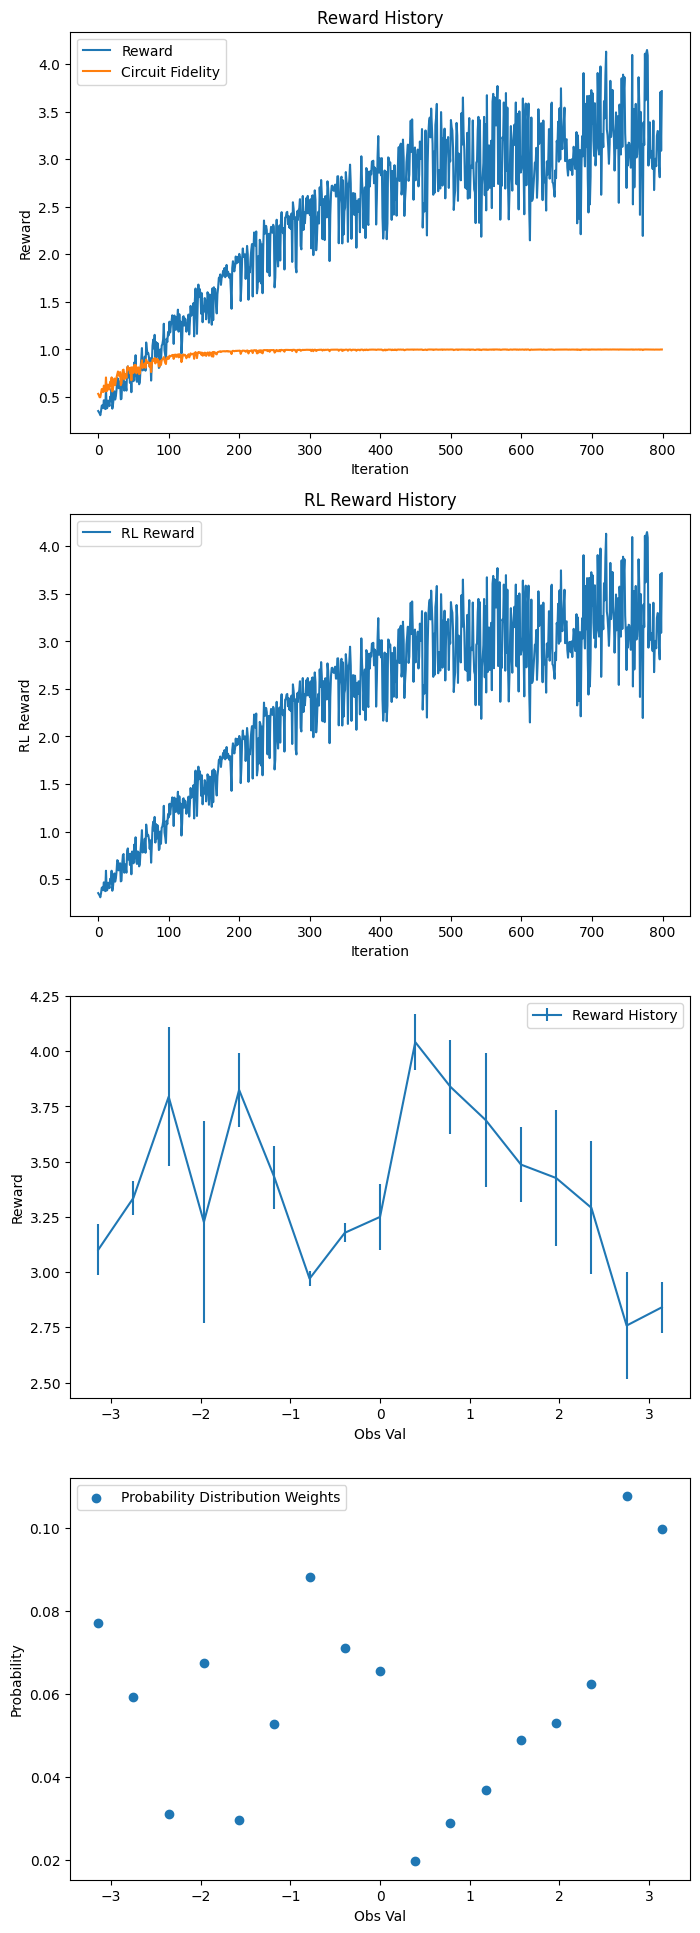

model saved to runs/PPO_CleanRL__Test PPO CleanRL__1__1741836665/Test PPO CleanRL.cleanrl_model


In [ ]:
q_env.clear_history()
ppo_agent.run_training()

[0.35228584 0.33950471 0.32697988 0.30844728 0.35083149 0.40825912
 0.41365338 0.38258258 0.46541655 0.40511629 0.37292697 0.5876188
 0.37935626 0.38792936 0.46239141 0.43157008 0.40507956 0.50352152
 0.45655409 0.58768736 0.37729926 0.42309011 0.50282456 0.55929262
 0.47314382 0.5068761  0.57865897 0.69890893 0.6912033  0.59217423
 0.62490066 0.66622539 0.47585344 0.48146573 0.65772182 0.75274028
 0.76344607 0.56695667 0.65610611 0.62357756 0.56723851 0.79470257
 0.82242242 0.70583031 0.76024013 0.64813412 0.76672484 0.55029857
 0.79009241 0.77522204 0.66597787 0.86184742 0.71933819 0.93952406
 0.68140329 0.65869056 0.79090621 0.78092701 0.63350595 0.65549255
 0.800163   0.89439866 1.01451588 0.77954485 0.83527228 0.8012852
 0.92475395 0.77647458 1.07338045 0.99738281 0.95672741 0.96117196
 0.91502139 0.81803754 0.90797329 0.67251953 0.84445937 1.03980801
 1.10301454 1.0098033  1.15379566 0.88424682 1.07873062 0.92605815
 1.06665657 1.01151395 0.8051847  0.81789399 0.99894505 0.871254

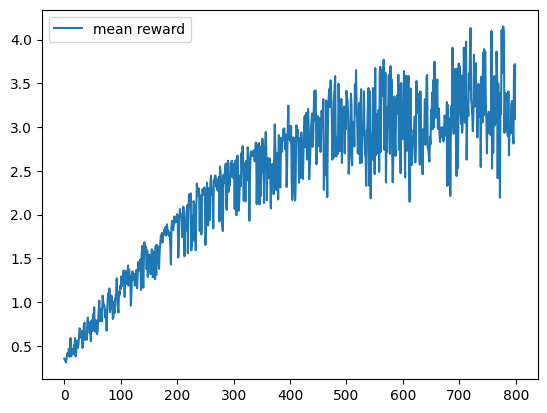

In [ ]:
reward_history = np.array(ppo_agent.env.reward_history)
mean_history = np.mean(reward_history, axis=1)
print(mean_history)

plt.plot(mean_history, label='mean reward')
plt.legend()
plt.show()

In [ ]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.discrete_obs_vals:
    next_obs = torch.Tensor(np.tile(sample_obs / np.pi, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        ppo_agent.env.action_space.low,
        ppo_agent.env.action_space.high,
    )
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [ ]:
print(std_actions)

[array([0.00840806, 0.        , 0.        , 0.00686307, 0.00782023,
       0.00791938, 0.00851955], dtype=float32), array([0.00821067, 0.        , 0.        , 0.00749316, 0.00959281,
       0.00745607, 0.00931366], dtype=float32), array([0.00708341, 0.        , 0.        , 0.00828699, 0.00707044,
       0.00983353, 0.00769269], dtype=float32), array([0.0084755 , 0.        , 0.        , 0.0064568 , 0.0081405 ,
       0.00661372, 0.00617186], dtype=float32), array([0.00878655, 0.        , 0.        , 0.00706721, 0.00875133,
       0.00870028, 0.00873908], dtype=float32), array([0.00667755, 0.        , 0.        , 0.0082079 , 0.0091409 ,
       0.00705011, 0.00961533], dtype=float32), array([0.00855197, 0.04222092, 0.03745341, 0.00665556, 0.0083941 ,
       0.00725184, 0.00876171], dtype=float32), array([0.00753876, 0.05585267, 0.04711905, 0.00864271, 0.00809465,
       0.00915708, 0.00857106], dtype=float32), array([0.00818533, 0.05304719, 0.03684858, 0.00715002, 0.00889941,
       0.006

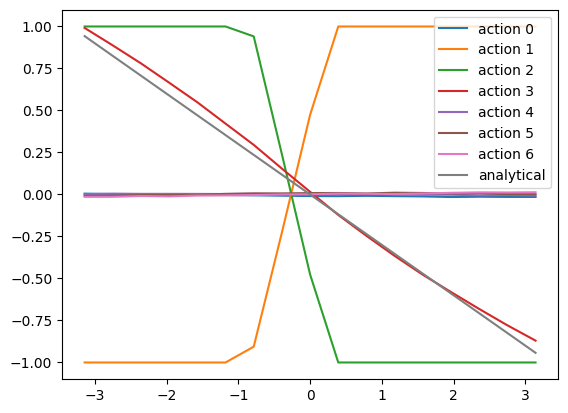

In [ ]:
actions = np.array(actions)

o_vals = ppo_agent.env.discrete_obs_vals
ana_sum = -o_vals * 0.3

for i in range(len(actions[0])):
    plt.plot(o_vals, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(o_vals, ana_sum, label=f'analytical')
plt.legend()
plt.show()

In [ ]:
print(actions[0])

[ 0.00502113 -1.          1.          0.9912547   0.00157621 -0.00834813
 -0.01409131]


In [ ]:
# Testing fidelity of agents

import copy

rewards = []

action_test = copy.deepcopy(actions)

for i, sample_obs in enumerate(ppo_agent.env.discrete_obs_vals):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = ppo_agent.env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    # act[3] = ana_sum[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (32, 1))
    obs, reward, terminated, truncated, info = q_env.step(batch_action)
    rewards.append(np.mean(reward))


 Number of repetitions: 6
Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9995242573108909
obs: [-1.]
reward: [3.32262788 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788
 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788
 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788
 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788
 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788 3.32262788
 3.32262788 3.32262788]

 Number of repetitions: 6
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.999218882708848
obs: [-0.875]
reward: [3.10728375 3.10728375 3.10728375 3.1072

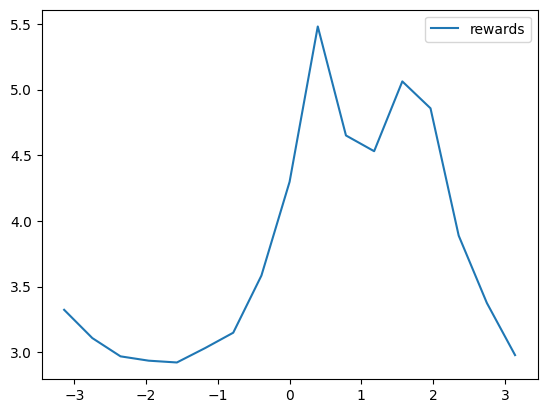

In [ ]:
plt.plot(ppo_agent.env.discrete_obs_vals, rewards, label='rewards')
plt.legend()
plt.show()